In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from autogluon.tabular import TabularPredictor

c:\Users\ldani\Documents\Patronus\Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Directorio de los archivos CSV
directory = "D:\\DESK\\PATRONUS\\simulated-obstructive-disease-respiratory-pressure-and-flow-1.0.0\\PQ_ProcessedData"

In [5]:
def extract_peep_epoc(filename):
    parts = filename.split('_')
    peep = int(parts[2].replace('cmH2O', ''))
    epoc = int(parts[3].replace('mL.csv', ''))
    return peep, epoc

In [6]:
def load_and_normalize_data(directory):
    data = []
    targets = []
    feature_names = ['Pressure_mean', 'Flow_mean', 'V_tidal_mean', 
                    'Pressure_std', 'Flow_std', 'V_tidal_std', 
                    'Pressure_max', 'Flow_max', 'V_tidal_max', 
                    'Pressure_min', 'Flow_min', 'V_tidal_min', 
                    'Pressure_median', 'Flow_median', 'V_tidal_median', 
                    'Pressure_iqr', 'Flow_iqr', 'V_tidal_iqr', 
                    'Pressure_skew', 'Flow_skew', 'V_tidal_skew', 
                    'Pressure_kurtosis', 'Flow_kurtosis', 'V_tidal_kurtosis', 
                    'PEEP']
    
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            
            # Normalizar las señales
            scaler = StandardScaler()
            df[['Pressure [cmH2O]', 'Flow [L/s]', 'V_tidal [L]']] = scaler.fit_transform(df[['Pressure [cmH2O]', 'Flow [L/s]', 'V_tidal [L]']])
            
            # Calcular características una por una
            features = []
            features.append(df['Pressure [cmH2O]'].mean())       # Media de la presión
            features.append(df['Flow [L/s]'].mean())            # Media del flujo
            features.append(df['V_tidal [L]'].mean())           # Media del volumen tidal
            
            features.append(df['Pressure [cmH2O]'].std())        # Desviación estándar de la presión
            features.append(df['Flow [L/s]'].std())             # Desviación estándar del flujo
            features.append(df['V_tidal [L]'].std())            # Desviación estándar del volumen tidal
            
            features.append(df['Pressure [cmH2O]'].max())        # Máximo de la presión
            features.append(df['Flow [L/s]'].max())             # Máximo del flujo
            features.append(df['V_tidal [L]'].max())            # Máximo del volumen tidal
            
            features.append(df['Pressure [cmH2O]'].min())        # Mínimo de la presión
            features.append(df['Flow [L/s]'].min())             # Mínimo del flujo
            features.append(df['V_tidal [L]'].min())            # Mínimo del volumen tidal
            
            features.append(df['Pressure [cmH2O]'].median())     # Mediana de la presión
            features.append(df['Flow [L/s]'].median())          # Mediana del flujo
            features.append(df['V_tidal [L]'].median())         # Mediana del volumen tidal
            
            # Rango intercuartil (IQR)
            features.append(df['Pressure [cmH2O]'].quantile(0.75) - df['Pressure [cmH2O]'].quantile(0.25)) 
            features.append(df['Flow [L/s]'].quantile(0.75) - df['Flow [L/s]'].quantile(0.25))
            features.append(df['V_tidal [L]'].quantile(0.75) - df['V_tidal [L]'].quantile(0.25))
            
            # Skewness
            features.append(skew(df['Pressure [cmH2O]']))
            features.append(skew(df['Flow [L/s]']))
            features.append(skew(df['V_tidal [L]']))
            
            # Kurtosis
            features.append(kurtosis(df['Pressure [cmH2O]']))
            features.append(kurtosis(df['Flow [L/s]']))
            features.append(kurtosis(df['V_tidal [L]']))
            
            # Extraer PEEP y EPOC del nombre del archivo
            peep, epoc = extract_peep_epoc(filename)
            
            # Incluir PEEP como característica
            features.append(peep)
            
            data.append(features)
            targets.append(epoc)
    
    return pd.DataFrame(data, columns=feature_names), pd.DataFrame(targets, columns=['EPOC'])


In [164]:
# Definir los modelos y sus respectivos espacios de hiperparámetros
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1, 10]
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
}

In [165]:
# Crear modelo de ML y evaluar
def create_and_evaluate_models(data, targets):
    X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, random_state=42)
    
    best_estimators = {}
    for name, model_info in models.items():
        print(f"Training {name} model...")
        model = model_info['model']
        params = model_info['params']
        search = RandomizedSearchCV(model, params, n_iter=10, cv=5, random_state=42, n_jobs=-1)
        search.fit(X_train, y_train)
        best_estimators[name] = search.best_estimator_
        
        y_pred = search.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        print(f"Best parameters for {name}: {search.best_params_}")
        print(f"Accuracy for {name}: {accuracy}")
        print(f"Classification Report for {name}:\n{report}")
        print("----------------------------------------------------")
    
    return best_estimators

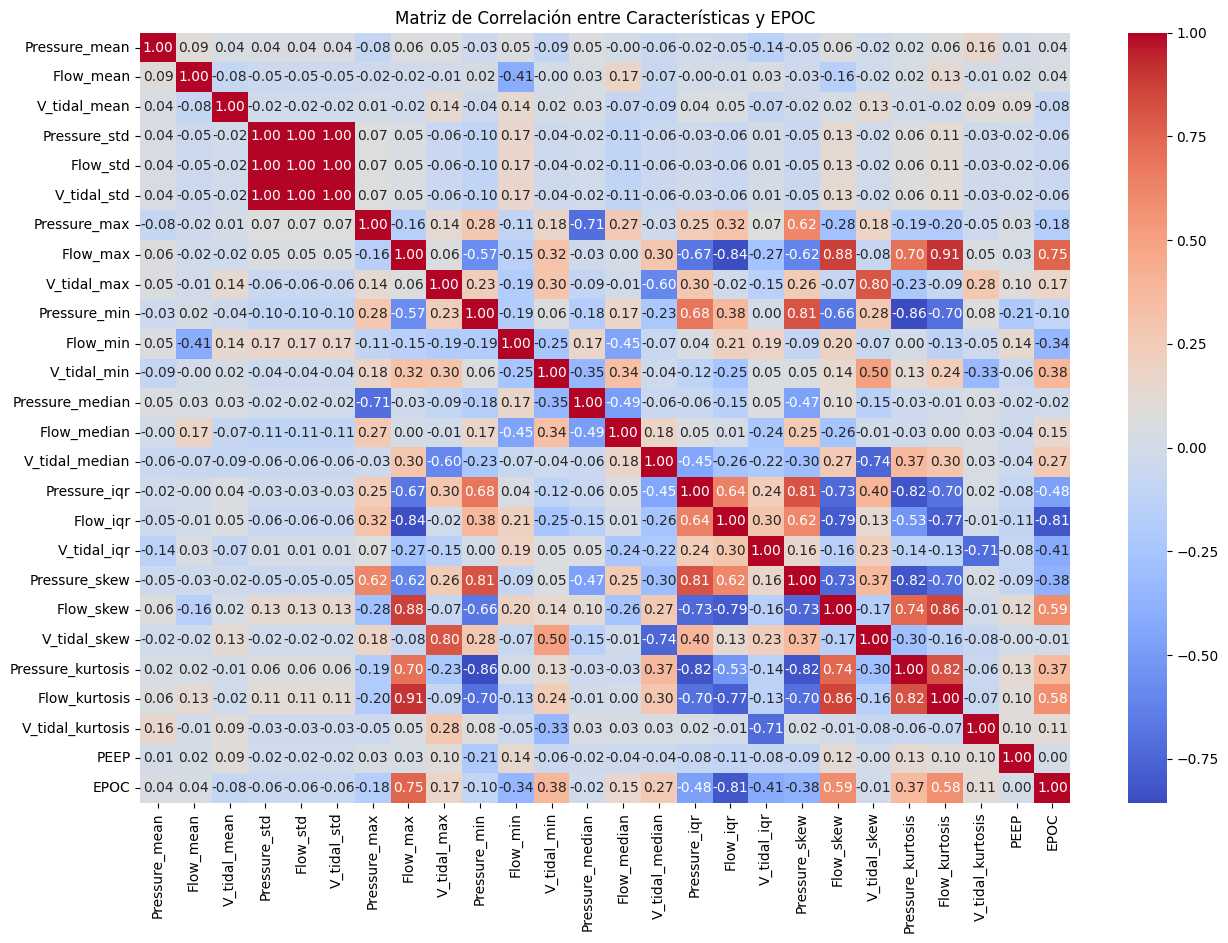

In [166]:
# Ejecutar el flujo de trabajo y crear la matriz de correlación
data, targets = load_and_normalize_data(directory)
correlation_matrix = pd.concat([data, targets], axis=1).corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación entre Características y EPOC')
plt.show()

In [167]:
data

,Pressure_mean,Flow_mean,V_tidal_mean,Pressure_std,Flow_std,V_tidal_std,Pressure_max,Flow_max,V_tidal_max,Pressure_min,...,Pressure_iqr,Flow_iqr,V_tidal_iqr,Pressure_skew,Flow_skew,V_tidal_skew,Pressure_kurtosis,Flow_kurtosis,V_tidal_kurtosis,PEEP
0,-4.229421e-18,-4.229421e-18,-1.120797e-16,1.000149,1.000149,1.000149,1.333050,1.674177,2.554750,-1.754271,...,2.066400,2.101332,1.672024,-0.510854,0.514525,0.134898,-1.459087,-1.557781,-0.785986,0
1,1.015061e-16,-3.383537e-17,-8.458842e-18,1.000149,1.000149,1.000149,1.193265,3.663316,1.782730,-2.574609,...,0.838706,0.704069,0.935421,-1.269593,1.688860,-1.223205,0.146910,1.967013,1.405727,0
2,1.438003e-16,1.268826e-17,-3.383537e-17,1.000149,1.000149,1.000149,1.014842,3.116593,2.835574,-2.453033,...,0.832497,0.199408,1.361860,-1.353716,1.851264,0.344125,0.478579,2.073100,-0.047145,0
3,2.030122e-16,3.383537e-17,-6.767074e-17,1.000149,1.000149,1.000149,1.663877,3.359976,1.926867,-2.387036,...,0.948754,0.613196,1.201100,-0.985099,1.808335,-0.581703,0.022721,2.449378,-0.367159,0
4,-2.749124e-17,1.480297e-17,-2.992315e-16,1.000149,1.000149,1.000149,1.633839,1.515303,2.060782,-1.905006,...,1.943760,2.065648,1.714307,-0.300375,0.226290,0.121222,-1.430646,-1.759033,-1.071229,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,-1.954726e-16,6.515752e-18,5.212601e-17,1.000115,1.000115,1.000115,1.360424,3.036308,1.616560,-2.367875,...,0.801515,0.828548,1.203754,-1.134085,1.454968,-0.985725,0.414293,1.386142,-0.284706,4
236,-5.864177e-17,-2.443407e-17,2.443407e-16,1.000115,1.000115,1.000115,1.343487,1.418328,2.061189,-1.860420,...,1.997240,2.069390,1.687204,-0.358200,0.302165,0.027408,-1.684922,-1.843876,-1.063375,8
237,3.909451e-17,-6.515752e-18,-3.909451e-17,1.000115,1.000115,1.000115,1.587249,3.205417,1.985835,-2.451519,...,0.855469,0.675590,1.333783,-1.091911,1.855087,-0.610395,0.365557,2.203689,-0.217666,8
238,-5.082286e-16,7.818902e-17,-1.303150e-16,1.000115,1.000115,1.000115,1.482639,3.353842,1.827134,-2.597536,...,0.964397,0.288589,1.626603,-1.193902,1.708048,-0.316403,0.585511,2.588721,-0.995266,8


In [168]:
# Entrenar y evaluar modelos con toda la data
best_estimators = create_and_evaluate_models(data, targets)

Training RandomForest model...


c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best parameters for RandomForest: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}
Accuracy for RandomForest: 0.4166666666666667
Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
         200       0.50      0.20      0.29        15
         250       0.27      0.33      0.30        12
         300       0.07      0.11      0.08         9

    accuracy                           0.42        48
   macro avg       0.46      0.41      0.42        48
weighted avg       0.49      0.42      0.43        48

----------------------------------------------------
Training KNN model...
Best parameters for KNN: {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan'}
Accuracy for KNN: 0.4375
Classification Report for KNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
         200       0.29      

c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.46855601 0.44750337
 0.45330634 0.42726046 0.42726046 0.42726046]
  warnings.warn(
c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters for GradientBoosting: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 5, 'learning_rate': 0.01}
Accuracy for GradientBoosting: 0.4583333333333333
Classification Report for GradientBoosting:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
         200       0.33      0.07      0.11        15
         250       0.33      0.42      0.37        12
         300       0.22      0.44      0.30         9

    accuracy                           0.46        48
   macro avg       0.47      0.48      0.44        48
weighted avg       0.48      0.46      0.43        48

----------------------------------------------------
Training DecisionTree model...
Best parameters for DecisionTree: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}
Accuracy for DecisionTree: 0.4375
Classification Report for DecisionTree:
              precision    recall  f1-score   support

           0       1.00      1.00    

c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Us

Best parameters for AdaBoost: {'n_estimators': 50, 'learning_rate': 0.01}
Accuracy for AdaBoost: 0.4375
Classification Report for AdaBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
         200       0.33      0.07      0.11        15
         250       0.00      0.00      0.00        12
         300       0.24      0.89      0.38         9

    accuracy                           0.44        48
   macro avg       0.39      0.49      0.37        48
weighted avg       0.40      0.44      0.36        48

----------------------------------------------------
Training ExtraTrees model...
Best parameters for ExtraTrees: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20}
Accuracy for ExtraTrees: 0.4583333333333333
Classification Report for ExtraTrees:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
         200       0.33      0.20 

c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
